In [2]:
import copy
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima, FakeSherbrooke, FakeLimaV2, FakeWashington
from qiskit import QuantumCircuit, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}

In [3]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [4]:
real_backend = provider.get_backend('ibm_sherbrooke')
# real_backend = provider.get_backend('ibm_washington')

In [5]:
fake_backend = FakeSherbrooke() #FakeWashington() #FakeLima()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [27]:
import os
from tqdm.notebook import tqdm
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)])
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                # ideal_exp_vals.append(entry['ideal_exp_value'])
                # noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits #, ideal_exp_vals, noisy_exp_vals

train_circuits = load_circuits('./data/ising_zne_hardware/10q_sherbrooke', '.pk')

  0%|          | 0/10 [00:00<?, ?it/s]

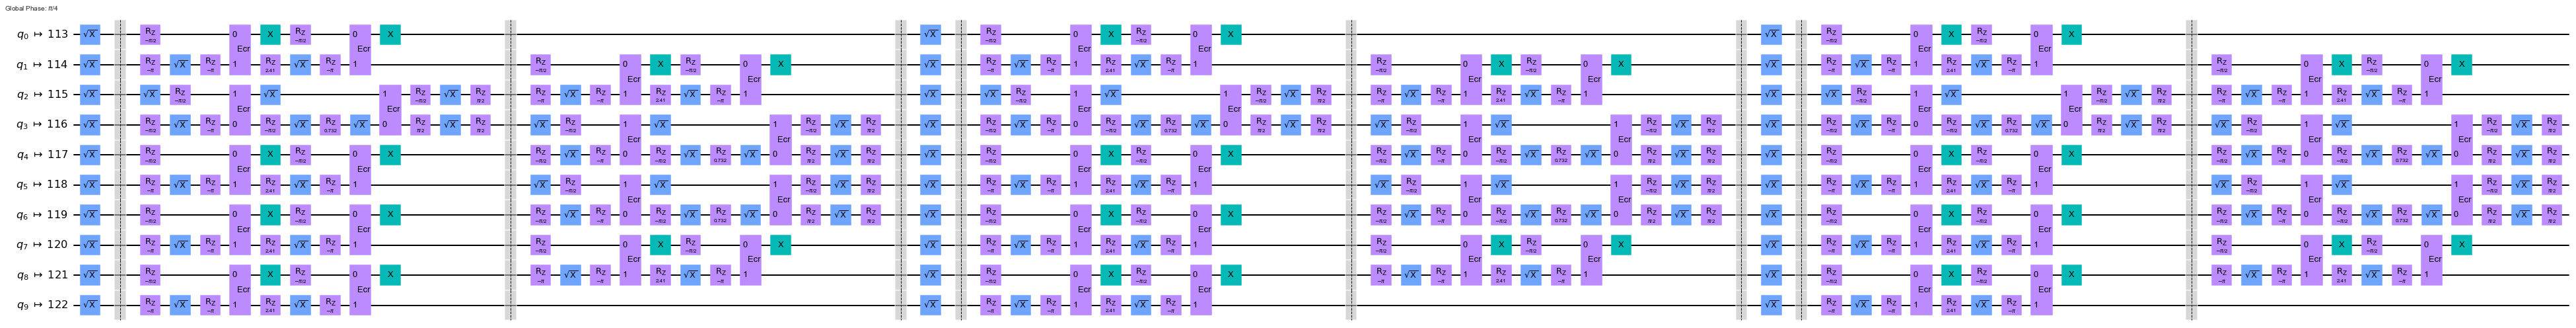

In [7]:
train_circuits[61].remove_final_measurements()
train_circuits[61].draw(**D)

In [9]:
def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

In [10]:
# obs_list = ['I'*i+'Z'+'I'*(6-1-i) for i in range(6)]
# padded_obs = [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 6), 127)) for obs in obs_list]

obs_list = ['Z'+'I'*9, 'I'*2+'Z'+'I'*7, 'I'*4+'Z'+'I'*5, 'I'*6+'Z'+'I'*3, 'I'*9+'Z'+'I'*0]
padded_obs_all_circs = []
for trans_circuit in tqdm(train_circuits):
    padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 10), 127)) for obs in obs_list]

# obs_list = ['Z'+'I'*99, 'I'*19+'Z'+'I'*80, 'I'*29+'Z'+'I'*70, 'I'*39+'Z'+'I'*60, 'I'*49+'Z'+'I'*50]
# padded_obs_all_circs = []
# for trans_circuit in tqdm(train_circuits):
#     padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

  0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
for i in range(150, 155):
    print(126-padded_obs_all_circs[i].paulis.to_labels()[0].find('Z'))

113
115
117
119
122


In [12]:
with open('./data/ising_zne_hardware/10q_sherbrooke_30persteps_job_ids.pk', 'rb') as file:
    loaded = pickle.load(file)
loaded

['chsdqfhoq2qn3r0u98qg',
 'chsdqg391dmpcnnl2ir0',
 'chsdqggrecnk2p3h20ig',
 'chsdqh8recnk2p3h212g',
 'chsdqhorecnk2p3h21k0',
 'chsdqij91dmpcnnl2lc0',
 'chsdqjbgsimdkukloc7g',
 'chsdqjpvrup8980e7q3g',
 'chsdqkqi3durlgprc8j0',
 'chsdqlrgsimdkukloep0']

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
service = QiskitRuntimeService()

In [141]:
ret_job_result = service.job('chsdqfhoq2qn3r0u98qg').result()
ret_job_result.metadata[10]['zne']['noise_amplification']#['values'][0]

{'noise_amplifier': "<CxAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
 'noise_factors': [1, 3],
 'values': [-0.0185, 0.023],
 'variance': [0.99965775, 0.999471],
 'shots': [4000, 4000]}

0.0165

In [115]:
mitigated_vals = []
noisy_vals = []
for job_id in tqdm(loaded):
    ret_job_result = service.job(job_id).result()
    mitigated_values = ret_job_result.values
    for i in range(30):
        mitigated_vals.append(mitigated_values[i*5:(i+1)*5].tolist())
        noisy_vals.append([ret_job_result.metadata[j]['zne']['noise_amplification']['values'][0] for j in list(range(i*5,(i+1)*5))])

  0%|          | 0/10 [00:00<?, ?it/s]

In [117]:
cliff_mitigated_vals = []
cliff_noisy_vals = []
for job_id in tqdm(loaded):
    ret_job_result = service.job(job_id).result()
    mitigated_values = ret_job_result.values
    for i in range(1):
        cliff_mitigated_vals.append(mitigated_values[i*5:(i+1)*5].tolist())
        cliff_noisy_vals.append([ret_job_result.metadata[j]['zne']['noise_amplification']['values'][0] for j in list(range(i*5,(i+1)*5))])

  0%|          | 0/10 [00:00<?, ?it/s]

In [139]:
for x, y in zip(cliff_mitigated_vals, cliff_noisy_vals):
    print(x, y)

[0.020499999999999997, -0.0007500000000000007, 0.08624999999999998, 0.046000000000000006, -0.039499999999999987] [0.0165, 0.0015, 0.087, 0.0195, -0.0405]
[-0.843, -0.8672499999999997, -0.8722500000000001, -0.827, -0.8305] [-0.8445, -0.8665, -0.87, -0.8205, -0.8405]
[0.16725, -0.018500000000000003, 0.1004999999999999, 0.21875, 0.21649999999999997] [0.167, -0.025, 0.1125, 0.213, 0.226]
[0.8189999999999997, 0.7964999999999999, 0.7607499999999999, 0.7737499999999997, 0.8367499999999995] [0.8175, 0.8025, 0.7645, 0.7675, 0.8405]
[-0.1715, 0.04774999999999997, -0.12399999999999996, -0.13425, -0.217] [-0.168, 0.051, -0.125, -0.134, -0.221]
[-0.66825, -0.6302499999999999, -0.6499999999999997, -0.6324999999999995, -0.6277499999999999] [-0.665, -0.6205, -0.653, -0.636, -0.622]
[0.2885, -0.10849999999999997, 0.3037499999999999, 0.176, 0.33549999999999996] [0.2755, -0.0945, 0.271, 0.1775, 0.3225]
[0.5704999999999998, 0.5189999999999998, 0.4937499999999995, 0.5309999999999999, 0.5904999999999997] [0

# Verification

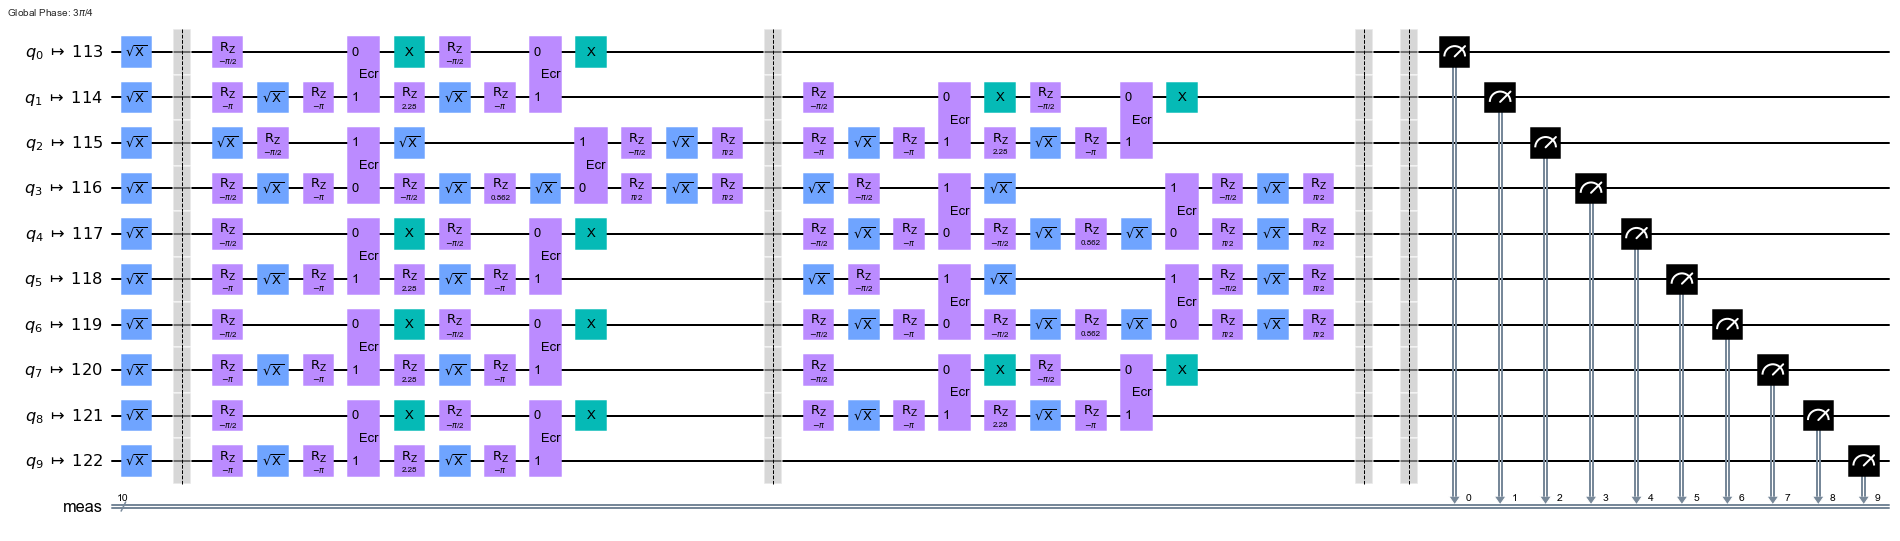

In [21]:
train_circuits[1].draw(**D)

In [76]:
from qiskit.result import marginal_counts
ideal_vals = []
for circ in tqdm(train_circuits):
    counts_ideal = AerSimulator().run(circ, shots=100000).result().get_counts()
    ideal_exp_vals = -1*cal_z_exp(marginal_counts(counts_ideal, [0, 2, 4, 6, 9]))
    ideal_vals.append(ideal_exp_vals.tolist())

  0%|          | 0/300 [00:00<?, ?it/s]

In [128]:
cliff_ideal_vals = []
for i in range(0, 300, 30):
    cliff_ideal_vals.append(ideal_vals[i])

In [119]:
to_df = []
steps = np.repeat(np.arange(1, 11), 30)

for i, (ideal_exp_val, noisy_exp_val, zne_mitigated, step) in tqdm(enumerate(zip(ideal_vals, noisy_vals, mitigated_vals, steps)), total=len(ideal_vals)):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val
    row['zne_mitigated'] = zne_mitigated
    row['step'] = step

    # circ_trans = transpile(circ, backend, optimization_level=3)
    # graph_data = circuit_to_graph_data_json(
    #             circuit=circ_trans,
    #             properties=properties,
    #             use_qubit_features=True,
    #             use_gate_features=True,
    #         )
    #
    # try:
    #     entry = ExpValueEntry(
    #         circuit_graph=graph_data,
    #         observable=[],
    #         ideal_exp_value=ideal_exp_val,
    #         noisy_exp_values=[noisy_exp_val],
    #         circuit_depth=circ_trans.depth()
    #     ).to_pyg_data()
    # except KeyError as e:
    #     print(f'Run into: {e}')
    #     continue
    #
    # X, _ = encode_data([circ_trans], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)
    #
    # for j, (model, name) in enumerate(models):
    #     if name == 'mlp':
    #         row[name] = model(X).tolist()[0]
    #     elif name == 'gnn':
    #         row[name] = model(entry.noisy_0,
    #                                 entry.observable,
    #                                 entry.circuit_depth,
    #                                 entry.x,
    #                                 entry.edge_index,
    #                                 entry.batch).tolist()[0]
    #     elif name in ['ols_full', 'rfr_full']:
    #         row[name] = model.predict(X).tolist()[0]
    #     elif name in ['ols', 'rfr']:
    #         row[name] = model.predict(X[:, -4:]).tolist()[0]
    #     elif name in ['rfr_list']:
    #         row[name] = []
    #         for q, m in enumerate(model):
    #             row[name].append(m.predict(X))
    #         row[name] = np.array(row[name]).transpose()[0]
    #     elif name in ['zne']:
    #         row[name] = zne_mitigated
    #     else:
    #         raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/300 [00:00<?, ?it/s]

In [120]:
df

,ideal,noisy,zne_mitigated,step
0,"[-0.0052, 0.0014, -0.00338, 0.00238, -0.00346]","[0.0165, 0.0015, 0.087, 0.0195, -0.0405]","[0.020499999999999997, -0.0007500000000000007,...",1
1,"[0.00054, 0.00392, 0.0008, 0.00434, -0.0]","[0.0245, 0.0435, 0.0115, 0.0505, 0.003]","[0.026249999999999992, 0.05174999999999998, 0....",1
2,"[-0.00176, -0.00172, 0.00656, 0.00222, -0.00204]","[-0.0185, 0.045, 0.006, 0.0745, -0.006]","[-0.03925000000000001, 0.05274999999999999, 0....",1
3,"[-0.00132, -0.0017, -0.00498, -0.00162, 0.00346]","[0.0405, 0.0375, 0.009, 0.1065, 0.002]","[0.05625000000000001, 0.0485, 0.01049999999999...",1
4,"[-0.00016, -0.0019, 0.00108, 0.00188, 0.0099]","[-0.007, 0.009, 0.0145, 0.0935, -0.0125]","[-0.00825, 0.0012499999999999855, 0.02475, 0.0...",1
...,...,...,...,...
295,"[-0.46086, -0.33794, -0.3396, -0.35066, -0.45992]","[-0.195, -0.25, 0.0575, 0.147, -0.0935]","[-0.19124999999999995, -0.25050000000000006, 0...",10
296,"[-0.02254, -0.02276, -0.02158, -0.02194, -0.02...","[0.0035, 0.013, 0.0165, 0.027, -0.005]","[0.001749999999999998, 0.018250000000000002, 0...",10
297,"[-0.04572, 0.01122, -0.01428, 0.02738, -0.04904]","[0.0605, 0.0435, 0.048, -0.0265, 0.0095]","[0.066, 0.061, 0.07525, -0.031499999999999986,...",10
298,"[-0.0677, 0.01018, -0.00058, 0.02838, -0.0646]","[0.067, 0.033, 0.021, 0.0085, -0.0015]","[0.07, 0.040249999999999994, 0.017999999999999...",10


In [121]:
df = pd.DataFrame(to_df)
def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

In [122]:
df_mean = df.groupby('step').agg('mean')
df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==1]))

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_77974/2927215234.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby('step').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_77974/2927215234.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==1]))


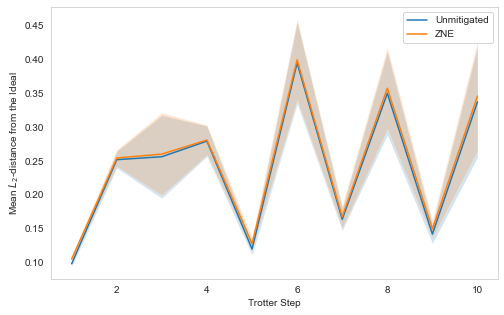

In [126]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
steps = sorted(set(df.step))
# legend_labels = ['Unmitigated', 'GNN Mitigated', 'MLP Mitigated', 'RF Mitigated', 'OLS Mitigated', 'ZNE Mitigated']
# for i, col in enumerate(['L2_noisy', 'L2_gnn', 'L2_mlp', 'L2_rfr_list', 'L2_ols_full', 'L2_zne']):
legend_labels = ['Unmitigated', 'ZNE']
for i, col in enumerate(['L2_noisy', 'L2_zne_mitigated']):
    plt.plot(steps, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
# plt.ylim([0, 0.64])
# plt.xlim([0, 29])
# plt.vlines(x=14, ymin=0, ymax=1, color='gray', label='Train data availability')
plt.legend()
plt.grid(None)
plt.show()

In [136]:
to_df = []
steps = np.repeat(np.arange(1, 11), 1)

for i, (ideal_exp_val, noisy_exp_val, zne_mitigated, step) in tqdm(enumerate(zip(cliff_ideal_vals, cliff_noisy_vals, cliff_mitigated_vals, steps)), total=len(cliff_ideal_vals)):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val
    row['zne_mitigated'] = zne_mitigated
    row['step'] = step

    # circ_trans = transpile(circ, backend, optimization_level=3)
    # graph_data = circuit_to_graph_data_json(
    #             circuit=circ_trans,
    #             properties=properties,
    #             use_qubit_features=True,
    #             use_gate_features=True,
    #         )
    #
    # try:
    #     entry = ExpValueEntry(
    #         circuit_graph=graph_data,
    #         observable=[],
    #         ideal_exp_value=ideal_exp_val,
    #         noisy_exp_values=[noisy_exp_val],
    #         circuit_depth=circ_trans.depth()
    #     ).to_pyg_data()
    # except KeyError as e:
    #     print(f'Run into: {e}')
    #     continue
    #
    # X, _ = encode_data([circ_trans], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)
    #
    # for j, (model, name) in enumerate(models):
    #     if name == 'mlp':
    #         row[name] = model(X).tolist()[0]
    #     elif name == 'gnn':
    #         row[name] = model(entry.noisy_0,
    #                                 entry.observable,
    #                                 entry.circuit_depth,
    #                                 entry.x,
    #                                 entry.edge_index,
    #                                 entry.batch).tolist()[0]
    #     elif name in ['ols_full', 'rfr_full']:
    #         row[name] = model.predict(X).tolist()[0]
    #     elif name in ['ols', 'rfr']:
    #         row[name] = model.predict(X[:, -4:]).tolist()[0]
    #     elif name in ['rfr_list']:
    #         row[name] = []
    #         for q, m in enumerate(model):
    #             row[name].append(m.predict(X))
    #         row[name] = np.array(row[name]).transpose()[0]
    #     elif name in ['zne']:
    #         row[name] = zne_mitigated
    #     else:
    #         raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_77974/388472823.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby('step').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_77974/388472823.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==1]))


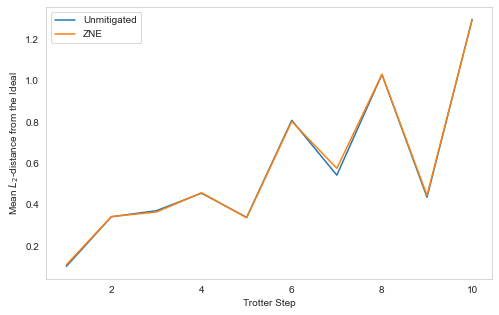

In [138]:
df = pd.DataFrame(to_df)
def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

df_mean = df.groupby('step').agg('mean')
df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==1]))

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
steps = sorted(set(df.step))
# legend_labels = ['Unmitigated', 'GNN Mitigated', 'MLP Mitigated', 'RF Mitigated', 'OLS Mitigated', 'ZNE Mitigated']
# for i, col in enumerate(['L2_noisy', 'L2_gnn', 'L2_mlp', 'L2_rfr_list', 'L2_ols_full', 'L2_zne']):
legend_labels = ['Unmitigated', 'ZNE']
for i, col in enumerate(['L2_noisy', 'L2_zne_mitigated']):
    plt.plot(steps, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
# plt.ylim([0, 0.64])
# plt.xlim([0, 29])
# plt.vlines(x=14, ymin=0, ymax=1, color='gray', label='Train data availability')
plt.legend()
plt.grid(None)
plt.show()